In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder 
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, KFold
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import tensorflow.keras.backend 
import shap

In [205]:
waste_df.tail()

2,Landfill*,Total Combustion with and without energy recovery,Composting,Recycling,total_waste
nan,,,,,
2014,136040,33190,23020,66150,258400
2015,137610,33550,23390,67560,262110
2016,140290,34170,25110,68540,268110
2017,140470,34220,26990,66980,268660
2018,146180,34560,24890,69020,292360


DATA Cleaning

In [2]:
df = (pd.read_excel("Demography.xlsx")
        .drop(["1980","1981","1982","1983","1984"] , axis = 1)
        .drop(0)
     )

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [4]:
demography_df = df.iloc[:,2:]

In [5]:
waste_df = pd.read_excel("historical_ff_data_1960-2018.xlsx")

In [6]:
waste_df.columns = waste_df.loc[2]
waste_df.drop([0,1,2,3,63],inplace = True)


In [7]:
waste_df.drop(['Combustion without Energy Recovery* ','Combustion with Energy Recovery','Food - other management',\
              'Generation lb/person/day'] ,axis = 1,inplace = True)

In [8]:
waste_df.index = np.arange(1,60)

In [9]:
finance_df = pd.read_excel("Demography.xlsx")

DATA inspection (Demography)

In [10]:
corr_demo = demography_df.transpose()


In [11]:
corr_demo.columns = corr_demo.iloc[0,:]
corr_demo.drop("Indicator Name", inplace = True)

In [12]:
corr_demo.reset_index(level = 0 , inplace = True)

<AxesSubplot:xlabel='Indicator Name', ylabel='Indicator Name'>

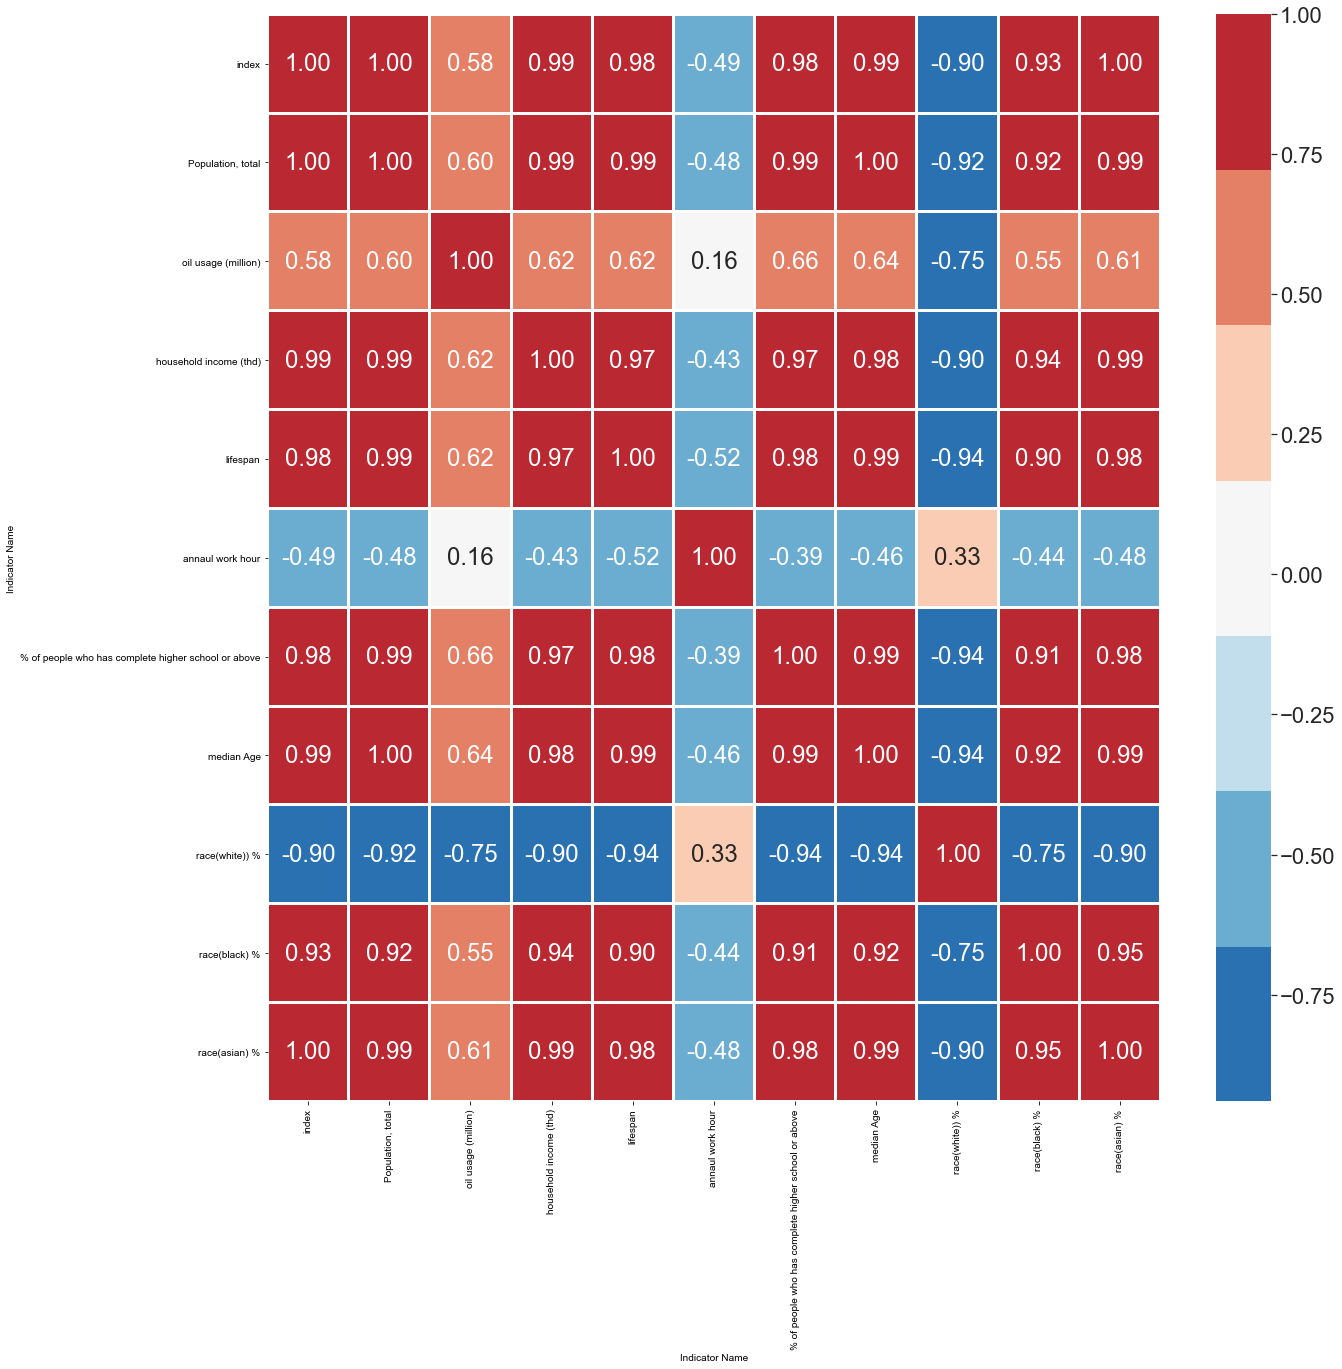

In [13]:
fig, axe = plt.subplots(figsize=(20,20))
sns.set_context("poster")
sns.set(font_scale=2)
map1 = sns.color_palette("RdBu_r", 7)
sns.heatmap(corr_demo.astype('float').corr(method= 'pearson'),annot=True, fmt='.2f',linewidths=2,cmap = map1)

In [14]:
waste_df.index = waste_df.iloc[:,0]
waste_df.drop(waste_df.columns[0],axis = 1, inplace = True)

<AxesSubplot:xlabel='2', ylabel='2'>

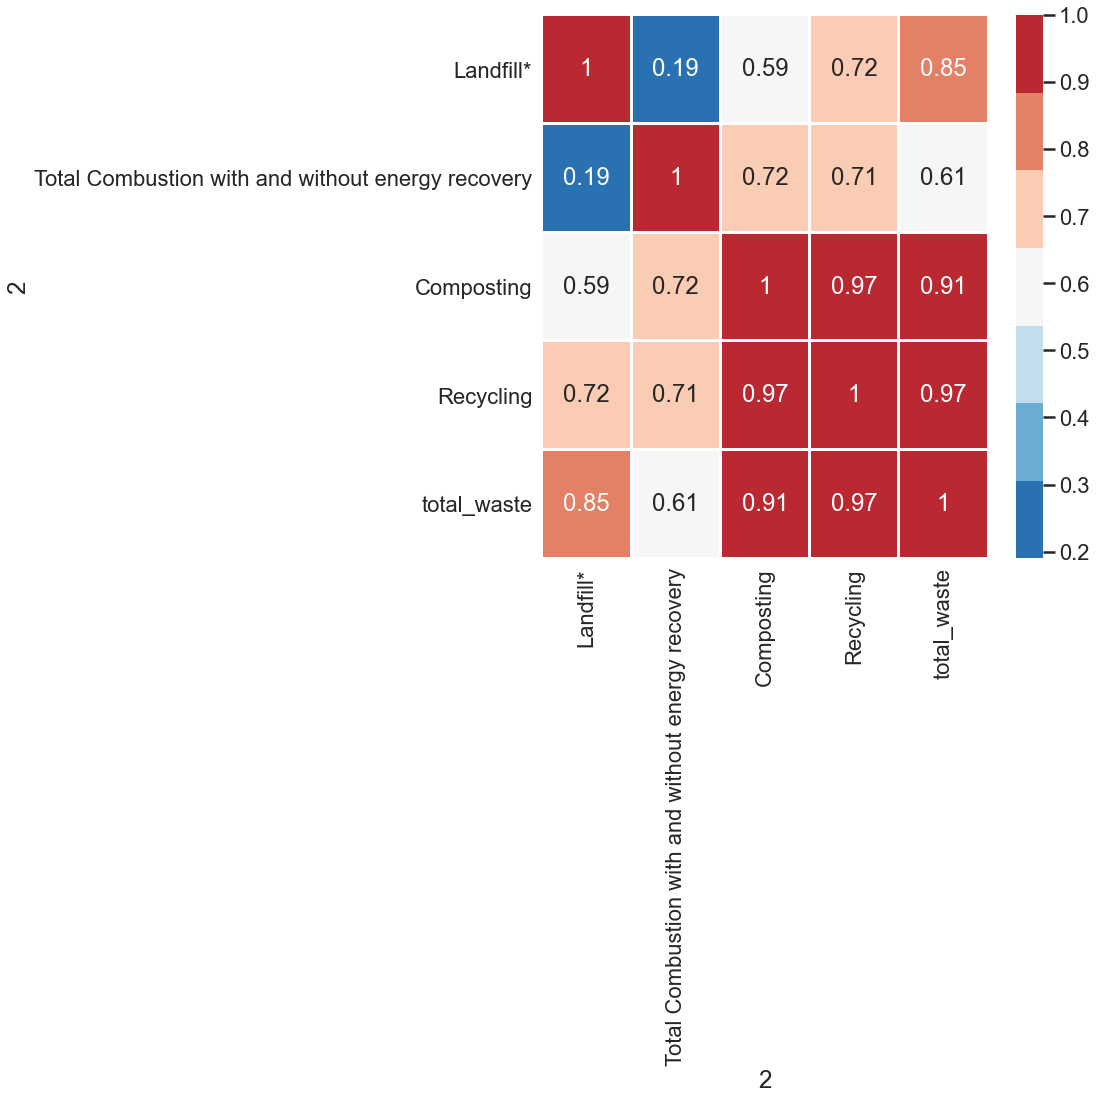

In [15]:
fig, axe = plt.subplots(figsize=(10,10))
sns.set_context("poster")
map1 = sns.color_palette("RdBu_r", 7)
sns.heatmap(waste_df.astype('float').corr(),annot=True,cmap = map1,linewidths=2)

For the waste heatmap, I will focus on the correlation between the total waste and waste processing ways.
The heatmap tells us a fact : When the waste in the USA increase, The gov will mainly spend more efforts on 
    compositing,  

In [16]:
fin_df = pd.read_csv("waste_company_financial_data_1985.csv")

In [17]:
fin_df.index = fin_df['datadate']

In [18]:
WM_df = fin_df.loc[fin_df['tic'] =='WM']
WM_df = WM_df['revt'].astype('float')

CLH_df = fin_df.loc[fin_df['tic']== 'CLH'] 
CLH_df = CLH_df['revt']
CLH_df.drop(19910228,inplace = True)
CLH_df.index = WM_df.index

CVA_df = fin_df.loc[fin_df['tic'] =='CVA']
CVA_df = CVA_df['revt'].astype('float')
CVA_df.drop(19901231,inplace = True)


WCN_df = fin_df.loc[fin_df['tic'] =='WCN']
WCN_df = WCN_df['revt'].astype('float')

RSG_df = fin_df.loc[fin_df['tic'] =='RSG']
RSG_df = RSG_df['revt'].astype('float')


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
total_waste = pd.DataFrame(waste_df.iloc[27:,4])
total_waste.index = WM_df.index

In [20]:
def reshape_fillzero(df):
    temp_df = pd.DataFrame(np.zeros(32,))
    temp_df.index = WM_df.index
    for i in df.index:
        temp_df.loc[i] = df[i]
    return temp_df


WCN_df = reshape_fillzero(WCN_df)
RSG_df = reshape_fillzero(RSG_df)
CVA_df = reshape_fillzero(CVA_df)

In [22]:
total_waste['CLH_rev'] = CLH_df

total_waste['WM_rev'] = WM_df
total_waste['CVA_rev'] = CVA_df
total_waste['WCN_rev'] = WCN_df
total_waste['RSG_rev'] = RSG_df

<AxesSubplot:>

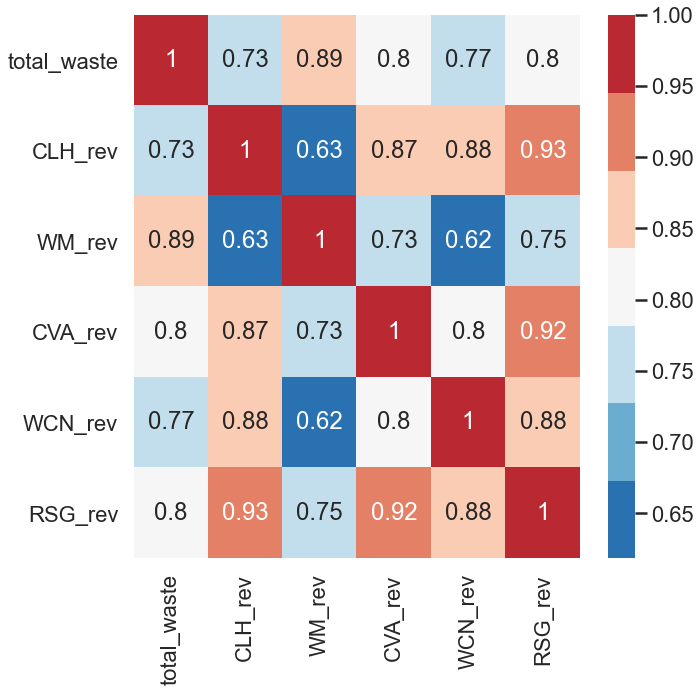

In [23]:
fig, axe = plt.subplots(figsize=(10,10))
sns.heatmap(total_waste.astype('float').corr(),annot = True,cmap =sns.color_palette("RdBu_r", 7))

In [24]:
corr_demo = corr_demo.iloc[2:,:] 
corr_demo.drop(34,inplace = True)
corr_demo.index = WM_df.index

In [25]:
corr_demo['total_waste'] =  total_waste.iloc[:,0]

In [26]:
#corr_demo.columns = corr_demo.loc['Indicator Name']
#corr_demo.drop('index', axis = 1 , inplace =True)
#corr_demo.drop('Indicator Name',inplace = True)


<AxesSubplot:xlabel='Indicator Name', ylabel='Indicator Name'>

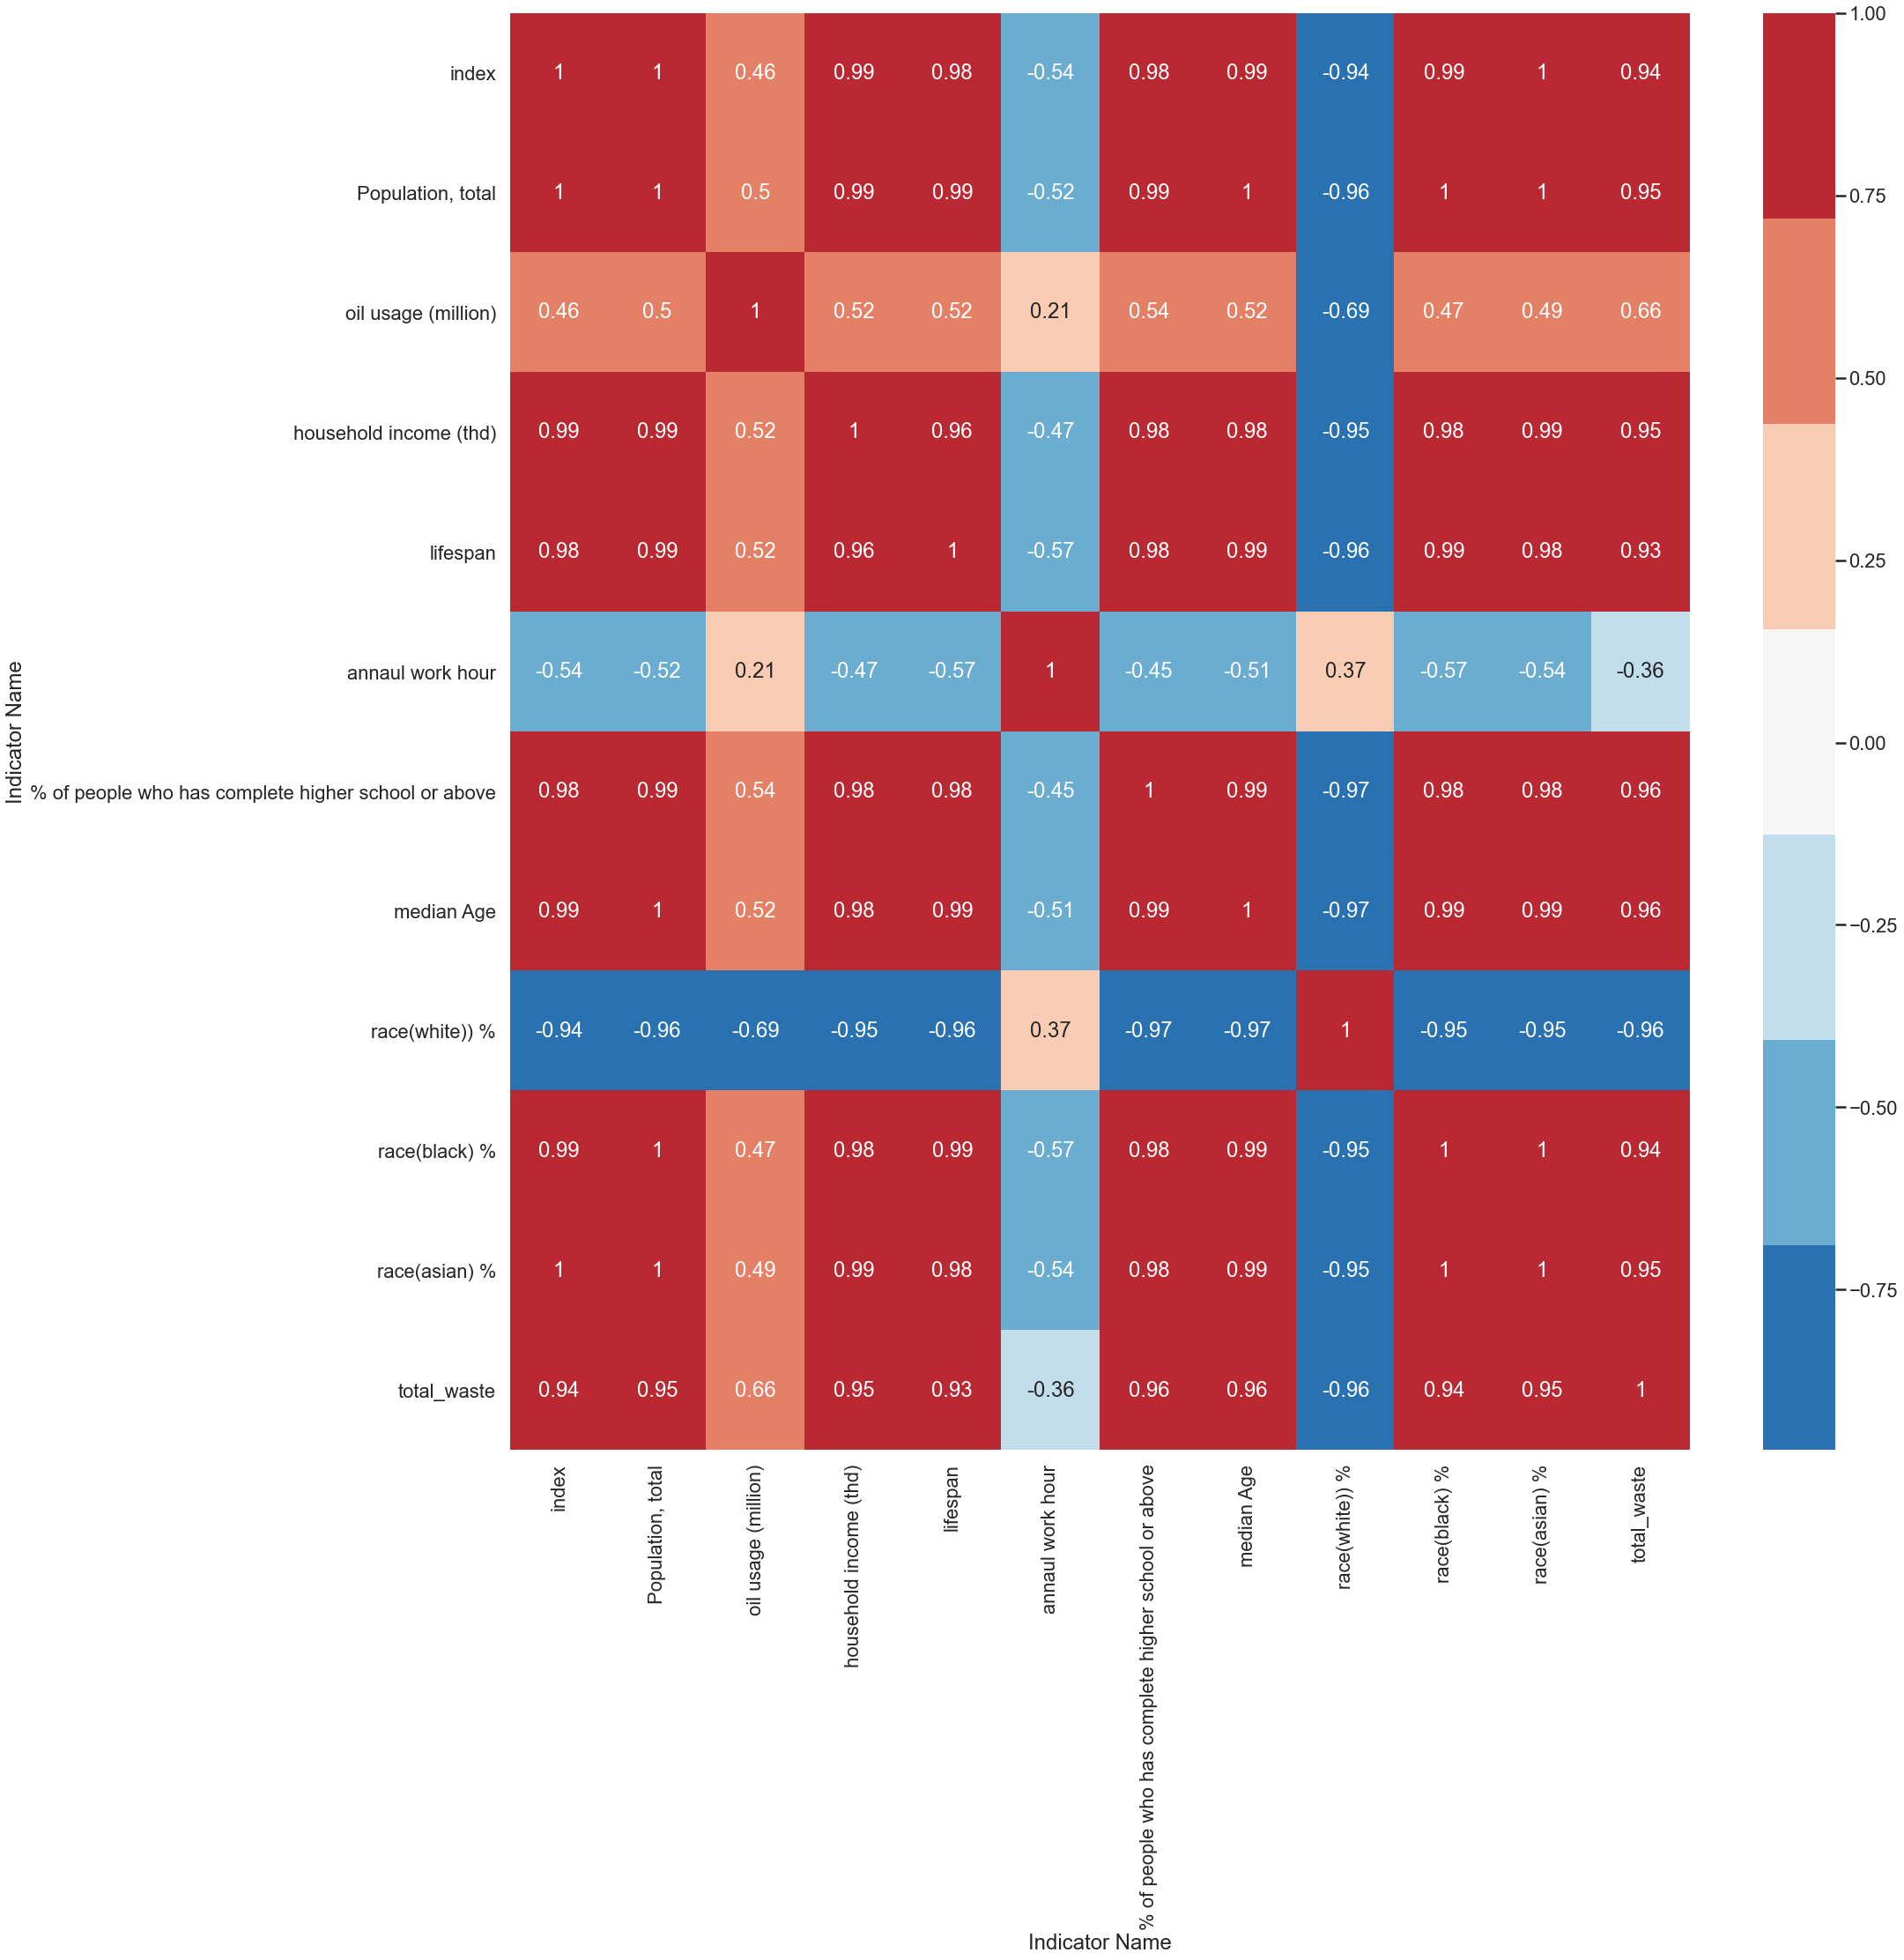

In [27]:
fig, axe = plt.subplots(figsize=(30,30))
sns.heatmap(corr_demo.astype('float').corr(),annot = True,cmap =sns.color_palette("RdBu_r", 7))


In [93]:
y = corr_demo['total_waste'].astype('float')
X = pd.DataFrame(corr_demo.iloc[:,1:11].astype('float'))


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state = 17)

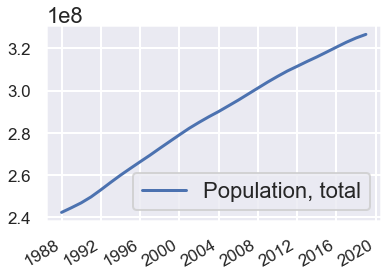

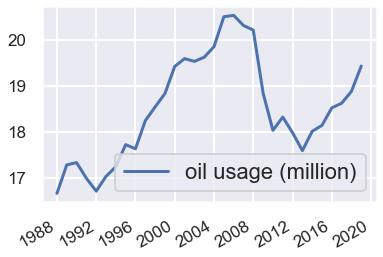

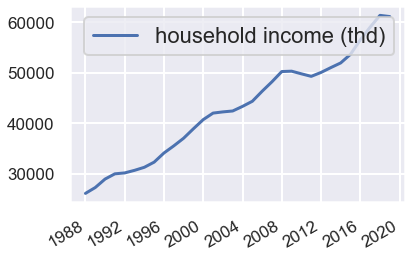

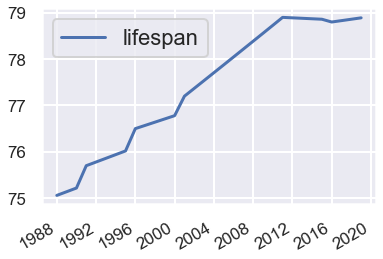

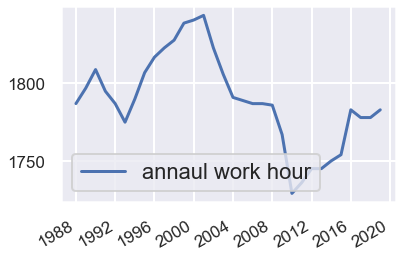

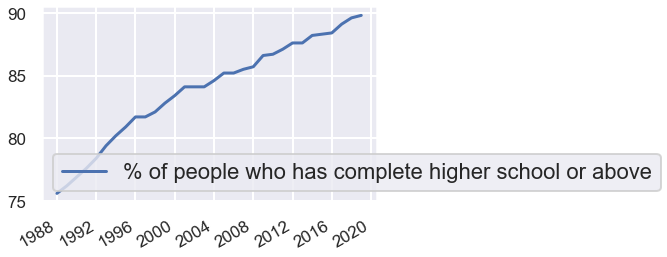

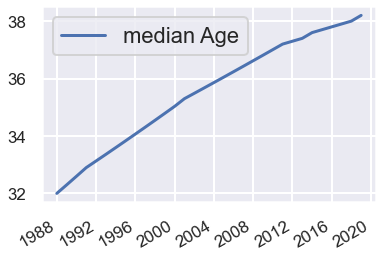

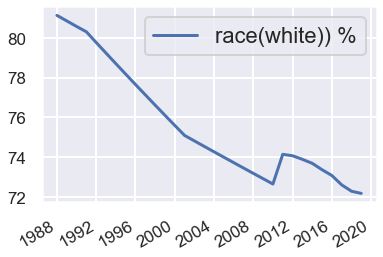

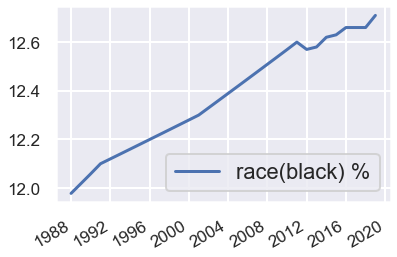

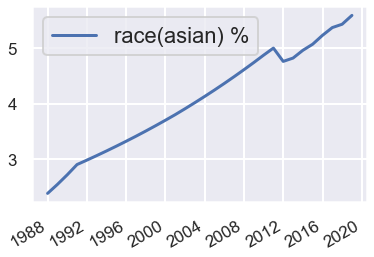

In [123]:
from matplotlib import dates

for j in range(len(X.columns)):
    fig, ax = plt.subplots()
    fig.autofmt_xdate()
    ax.tick_params(axis='both', which='major', labelsize=17)
    plt.plot(X.index,X.iloc[:,j])
    legend = plt.legend([X.columns[j]])





In [191]:
#predictions.shape
#
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

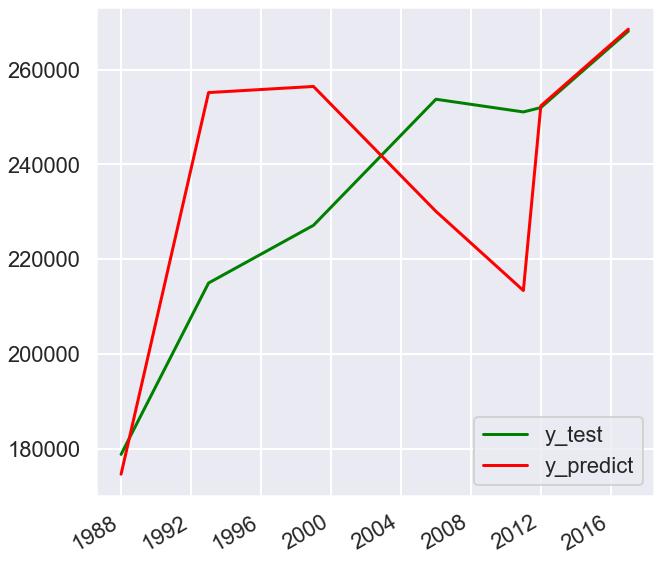

In [200]:
y_linear_pred = regressor.predict(X_test)

fig, ax = plt.subplots(figsize=(10,10))
fig.autofmt_xdate()
plt.plot(y_test.index, y_test, color = 'green')
plt.plot(y_test.index, y_linear_pred, color = 'red')
plt.legend(['y_test','y_predict'],loc = 'lower right')

In [196]:
r_sq = regressor.score(X,y)
print(f'r-sqare: %f' %r_sq)

print(r_sq, 1 - (1-regressor.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1))


r-sqare: 0.978389
0.9783886898188503 0.9680975897325885


In [42]:
X_adj = X.drop(['race(black) %','race(asian) %'],axis = 1)

In [39]:
def train_linear_m(X,y):
    regressor = LinearRegression()
    regressor.fit(X, y)

    predictions =  regressor.predict(X)
    mae = 0
    for i in range(0, len(predictions)):
        prediction = predictions[i]
        actual = y.iloc[i]

        error = abs(actual - prediction)
        mae = mae + error


    mean_error = mae / len(predictions)
    return mean_error
#train with all features
error1 = train_linear_m(X,y)
#drop the non_important feature
error2 = train_linear_m(X_adj,y)
print(f'mean mae with all features: %f' %error1)
print(f'mean mae with important features: %f' %error2)

mean mae with all features: 2919.177191
mean mae with important features: 2945.607767


R^2 result

In [45]:
regressor = LinearRegression()
regressor.fit(X_adj, y)


r_sq = regressor.score(X_adj,y)
print(f'r-sqare: %f' %r_sq)

r-sqare: 0.977979


r-sqare: 0.978389
0.9783886898188503 0.9680975897325885


In [ ]:
mae/mean 

32% of error

In [ ]:
mean

In [ ]:
intercept = regressor.intercept_
intercept

In [ ]:
features = pd.DataFrame(regressor.coef_, X.columns, columns=['coefficient'])

In [ ]:
features.coefficient = features.coefficient.abs()

In [ ]:
stdevs = []
for i in X.columns:
    stdev = corr_demo[i].std()
    stdevs.append(stdev)
 
features["stdev"] = np.array(stdevs).reshape(-1,1)
features["importance"] = features["coefficient"] * features["stdev"]


 coef *stdev gives an interpretation of the coefficient somehow independent of the scale.

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [ ]:
features

In [ ]:
features['importance_normalized'] = 100*features['importance'] / features['importance'].max()

In [ ]:
features.sort_values('importance_normalized', ascending = False)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
fig.autofmt_xdate()
plt.ylabel('importance score')
plt.title("Feature Importance")
ax.tick_params(axis='both', which='major', labelsize=17)
ax.bar(features.index, features.importance_normalized)

Should I Drop annaul work hour?

In [52]:
from statsmodels.tsa.stattools import adfuller
for i in X.columns:
    print(adfuller(X[i]))




(-4.099219137366061, 0.000971406931975016, 3, 28, {'1%': -3.6889256286443146, '5%': -2.9719894897959187, '10%': -2.6252957653061224}, 554.134366148501)
(-2.2523469991765124, 0.18779763784807985, 3, 28, {'1%': -3.6889256286443146, '5%': -2.9719894897959187, '10%': -2.6252957653061224}, 23.358171309968426)
(-1.0060219326128679, 0.7510616077675846, 6, 25, {'1%': -3.7238633119999998, '5%': -2.98648896, '10%': -2.6328004}, 337.1467966658067)
(-2.047852489667948, 0.2659933033317051, 5, 26, {'1%': -3.7112123008648155, '5%': -2.981246804733728, '10%': -2.6300945562130176}, -42.671126000834136)
(-1.7056890976536236, 0.42818369214278446, 1, 30, {'1%': -3.6699197407407405, '5%': -2.9640707407407407, '10%': -2.621171111111111}, 170.59138260474782)
(-3.1547771615661118, 0.022756175775885106, 0, 31, {'1%': -3.661428725118324, '5%': -2.960525341210433, '10%': -2.6193188033298647}, 9.163294754159736)
(-0.21724533640525867, 0.936434556958432, 10, 21, {'1%': -3.7883858816542486, '5%': -3.013097747543462

In [ ]:
corr_demo

In [ ]:
# 
# the more negative, the more likely it is stationary

In [98]:
X.index = pd.to_datetime(X.index.astype('str'), format = '%Y%m%d')

In [ ]:
#make a stationary data

In [124]:
df_stationary = X.diff().dropna()

In [127]:
X.shape

(32, 10)

In [126]:
df_stationary.shape

(31, 10)

XGB regression

In [137]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error


In [130]:
xgbr = XGBRegressor()
xgbr.fit(X_train,y_train)

Training score 0.9999999999981533


In [ ]:
#feature importance

In [202]:
X_train

Indicator Name,"Population, total",oil usage (million),household income (thd),lifespan,annaul work hour,% of people who has complete higher school or above,median Age,race(white)) %,race(black) %,race(asian) %
datadate,,,,,,,,,,
20061231,298379912.00,20.31,48201.00,78.22,1787.00,85.50,36.43,73.47,12.48,4.48
20131231,315993715.00,18.01,51939.00,78.87,1750.00,88.20,37.60,73.70,12.62,4.96
20151231,320635163.00,18.52,56516.00,78.80,1783.00,88.40,37.80,73.09,12.66,5.23
19901231,249623000.00,16.99,29943.00,75.70,1795.00,77.60,32.90,80.30,12.10,2.90
19891231,246819000.00,17.33,28906.00,75.22,1809.00,76.90,32.60,80.57,12.06,2.71
19971231,272657000.00,18.54,37005.00,76.64,1828.00,82.10,34.55,76.62,12.24,3.50
19951231,266278000.00,17.63,34076.00,76.50,1817.00,81.70,34.07,77.66,12.20,3.32
19961231,269394000.00,18.24,35492.00,76.57,1823.00,81.70,34.31,77.14,12.22,3.41
20171231,324985539.00,18.88,61372.00,78.86,1778.00,89.60,38.00,72.30,12.66,5.43


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

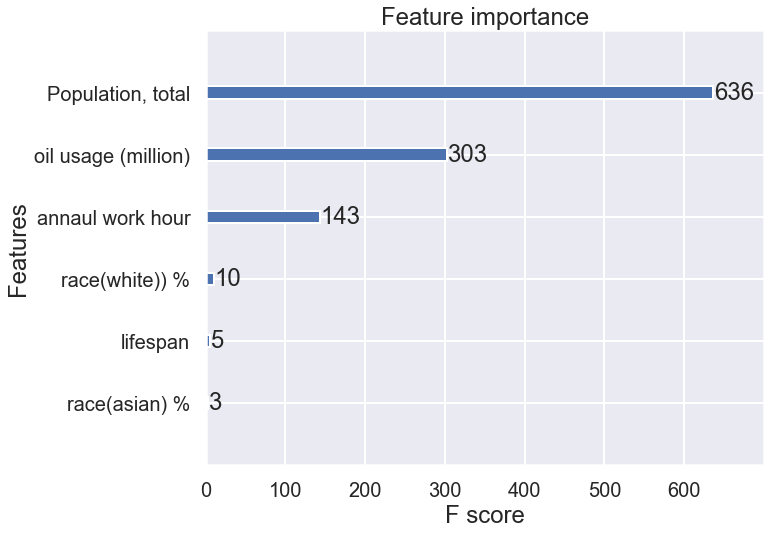

In [187]:
fig, ax = plt.subplots(figsize=(10,8))
ax.tick_params(axis='both', which='major', labelsize=20)
plot_importance(xgbr,ax = ax)

In [203]:
print(xgbr.feature_importances_)

[8.9545274e-01 1.8224813e-02 0.0000000e+00 1.9443253e-04 3.8800605e-02
 0.0000000e+00 0.0000000e+00 4.6970766e-02 0.0000000e+00 3.5665859e-04]


% of people who has complete higher school or above , median Age, race(black) % does not have feature value

I will not drop the columns with lower feature importance, In contrast to linear models, 
ML models can extract data from any feature.

In [136]:
cv_score = cross_val_score(xgbr, X_train, y_train, cv =5)
print("accuracy: ", cv_score.mean())

accuracy:  0.8523618110330713


In [140]:
ypred = xgbr.predict(X_test)
mae = mean_absolute_error(y_test, ypred)
print("MAE", mae)
#print()

MAE 3303.729910714286


In [166]:
y_test.index = pd.to_datetime(y_test.index.astype("str"),format = '%Y%m%d')
ypred = pd.DataFrame(ypred, index = y_test.index)



ValueError: time data '1987-12-31' does not match format '%Y%m%d' (match)

In [167]:
y_test.sort_index(inplace = True)
ypred.sort_index(inplace = True)

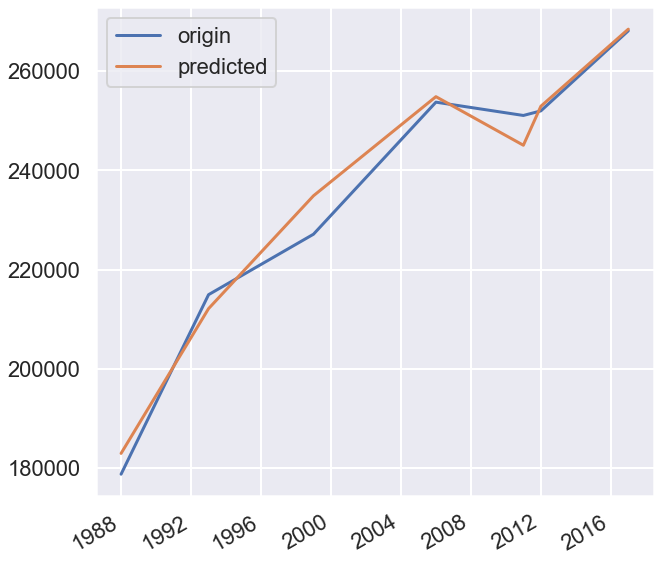

In [174]:
fig, ax = plt.subplots(figsize=(10,10))
plt.plot(y_test.index,y_test, label = 'origin')
plt.plot(ypred.index, ypred, label = 'predicted')
fig.autofmt_xdate()
plt.legend()
plt.show()

datadate
1987-12-31   178760.00
1992-12-31   214940.00
1998-12-31   227120.00
2005-12-31   253730.00
2010-12-31   251050.00
2011-12-31   251970.00
2016-12-31   268110.00
Name: total_waste, dtype: float64

,0
datadate,
1987-12-31,182952.02
1992-12-31,212127.48
1998-12-31,234864.89
2005-12-31,254837.83
2010-12-31,245048.92
2011-12-31,252902.78
2016-12-31,268445.00
